In [585]:
import gensim.models as gsm
import numpy as np
import json
import string
import collections
import itertools
import pickle
import random
import csv
import math
import re

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob

from scipy import spatial

In [569]:
### Load Word2Vec
w2v = gsm.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

In [570]:
### Load stop words from nltk
stop_cache = stopwords.words('english')

In [571]:
EMOTIONS = ['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise', \
            'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger']

CLONE_N = 30 ### The number of times we clone the data for the emotion with least number of data points

VALID_POS_LIST = ['NN', 'VB', 'JJ'] ### This one does better, i.e. nouns, verbs, and adjectives
#VALID_POS_LIST = ['NN', 'VB']

In [572]:
### Load data 
d = collections.defaultdict(list)
y = []

with open('text_emotion.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader, None)  # skip the headers
    for row in reader: 
        d[row[1]] += [row[3]]
        y.append(row[1])

In [574]:
### Investigate distribution of classes
count = collections.Counter(y)
count

Counter({'anger': 110,
         'boredom': 179,
         'empty': 827,
         'enthusiasm': 759,
         'fun': 1776,
         'happiness': 5209,
         'hate': 1323,
         'love': 3842,
         'neutral': 8638,
         'relief': 1526,
         'sadness': 5165,
         'surprise': 2187,
         'worry': 8459})

There is a clear data imbalance problem that will need to be corrected before we can train a classifier.

In [575]:
### Fix data imbalance
min_count = float('inf')
for emotion in EMOTIONS: 
    if count[emotion] < min_count: 
        min_count = count[emotion]
max_count_train = math.floor(0.8*min_count)
max_count_test = min_count - max_count_train

d_train = collections.defaultdict(list)
d_test = collections.defaultdict(list)

### Add all of data for the emotion with least data points
for emotion in EMOTIONS: 
    d_train[emotion] += d[emotion][:max_count_train]
    d_test[emotion] += d[emotion][max_count_train:min_count]
    d[emotion] = d[emotion][min_count:]

In [576]:
def fix_imbalance(emotions_list):
    for emotion in emotions_list:
        for ___ in range(CLONE_N):
            if len(d[emotion]) > min_count:
                d_train[emotion] += d[emotion][:max_count_train]
                d_test[emotion] += d[emotion][max_count_train:min_count]
                d[emotion] = d[emotion][min_count:]
            elif (len(d[emotion]) > 0) and (len(d[emotion]) < min_count):
                temp_min_count = len(d[emotion])
                temp_max_count_train = math.floor(0.8*temp_min_count)
                temp_max_count_test = len(d[emotion]) - temp_max_count_train
                d_train[emotion] += d[emotion][:temp_max_count_train]
                d_test[emotion] += d[emotion][temp_max_count_train:]
                d[emotion] = []
                d_train[emotion] += list(np.random.choice(d_train[emotion], size=max_count_train-temp_max_count_train, replace=False))
                d_test[emotion] += list(np.random.choice(d_test[emotion], size=max_count_test-temp_max_count_test, replace=False))
            elif len(d[emotion]) == 0: 
                d_train[emotion] += list(np.random.choice(d_train[emotion], size=max_count_train, replace=False))
                d_test[emotion] += list(np.random.choice(d_test[emotion], size=max_count_test, replace=False))

In [577]:
fix_imbalance(EMOTIONS)

x_train = []
y_train = []
x_test = []
y_test = []

for emotion in EMOTIONS: 
    x_train += d_train[emotion]
    y_train += [emotion for ___ in range(len(d_train[emotion]))]
    x_test += d_test[emotion]
    y_test += [emotion for ___ in range(len(d_test[emotion]))]

In [578]:
### Mix up data sets

combined = list(zip(x_train, y_train))
random.shuffle(combined)
x_train[:], y_train[:] = zip(*combined)

combined = list(zip(x_test, y_test))
random.shuffle(combined)
x_test[:], y_test[:] = zip(*combined)

In [579]:
### Take out URLs and @user instances
def clean(x):
    new_x = []
    for s in x:
        lst = []
        for word in s.split():
            if (word[0] != '@') and (word[:4] != 'http'):
                lst.append(word)
        new_x.append(' '.join(lst))
    return new_x

In [580]:
x_train = clean(x_train)
x_test = clean(x_test)

In [581]:
### Remove stop words, remove all words that aren't nouns, adjectives, or verbs, and then \
### take average of resultant word vectors
def vectorize(caption): 
    result = []
    for sent in sent_tokenize(caption):
        for word, pos in pos_tag(word_tokenize(sent)):
            s = word.translate(string.punctuation)
            for valid_pos in VALID_POS_LIST:
                if valid_pos in pos:
                    if s not in stop_cache: 
                        try: 
                            vec = np.zeros_like(w2v['hello'])
                            result.append(np.add(vec, w2v[s])) 
                        except: 
                            pass
                    break
    return result

In [582]:
### Get cosine distance of text captions in vector space from the approximate vector representations for each emotion
def distance_transformer(captions, emotions_list):
    result = []
    for caption in captions: 
        average_vec = np.mean(vectorize(caption), axis=0)
        to_append = []
        for emotion in emotions_list: 
            if emotions_list == EMOTIONS:
                dist = spatial.distance.cosine(average_vec, w2v[emotion])
            elif emotions_list == DENSE_EMOTIONS: 
                dist = spatial.distance.cosine(average_vec, np.mean([w2v[emo] for emo in DENSE_EMOTION_TO_EMOTIONS_DICT[emotion]], axis=0))
            if math.isnan(dist):
                to_append.append(1.0)
            else: 
                to_append.append(dist)
        result.append(to_append)
    return result

In [583]:
### Get polarity and subjectivity scores for sentiment analysis using WordBlob
def sentiment_transformer(captions): 
    result = []
    for caption in captions: 
        blob = TextBlob(caption)
        result.append([blob.sentiment[0]+1, blob.sentiment[1]])
    return result

In [586]:
### Plot accuracies of classifier for various value of top_n
def plot_top_n(classifier, preds):
    acc_x = []
    acc_y = []
    for top_n in range(0, len(classifier.classes_)+1):  
        acc_x.append(top_n)
        top_preds = []
        for probs in preds:
            classes = list(classifier.classes_)
            pairs = [(probs[i], classes[i]) for i in range(len(classes))]
            sorted_pairs = sorted(pairs, reverse=True)
            sorted_pairs = sorted_pairs[:top_n]
            top_preds.append([class_ for prob, class_ in sorted_pairs])

        score = 0
        for i in range(len(y_test)):
            if y_test[i] in top_preds[i]:
                score += 1
        acc = float(score/len(y_test))
        acc_y.append(acc)

    fig, ax = plt.subplots()
    ax.scatter(acc_x, acc_y, c='black')
    line = mlines.Line2D([0, len(classifier.classes_)], [0, 1], color='red')
    ax.add_line(line)
    plt.show()

In [584]:
dist_feature_train = distance_transformer(x_train, EMOTIONS)
dist_feature_test = distance_transformer(x_test, EMOTIONS)

#sent_feature_train = sentiment_transformer(x_train) #No added benefit
#sent_feature_test = sentiment_transformer(x_test)

#total_feature_train = [dist_feature_train[i] + sent_feature_train[i] for i in range(len(dist_feature_train))]
#total_feature_test = [dist_feature_test[i] + sent_feature_test[i] for i in range(len(dist_feature_test))]

/Users/ianscottknight/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ianscottknight/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Let's implement our first classifier, a simple naive bayes classifier where the input features are the cosine distances of the average vector of the word vectors of a given piece of text from the emotion words in vector space.

In [587]:
clf = MultinomialNB()
clf.fit(dist_feature_train, y_train)
print(accuracy_score(y_test, clf.predict(dist_feature_test)))
print(confusion_matrix(y_test, clf.predict(dist_feature_test)))

0.161403113016
[[  0  52   9   0  73   0 342  56  89   0   0   0  61]
 [ 22  99 116   0  62   2  35  35 192   0  60  16  43]
 [ 12  62 115  13  53   8 157  39 185  11   7   7  13]
 [  9  23  52  19  69  67 105  78 178  24  13  18  27]
 [ 11  37  77   7 115  49 117 118  77  26  11   3  34]
 [  4  20  72  17  78  82  70 175  99  27  11  16  11]
 [  8  69  89  23  30   4 266  35 128   3   6   7  14]
 [  1  12  53   7  42  45  63 341  68  18   8  12  12]
 [ 21  37 120   4  36  16 102  51 222  18  12  11  32]
 [  8  39  91   6  52  48  73 117 142  45   7  10  44]
 [ 13  50  72   7  39  22 148  91 137  12  33   9  49]
 [  7  37  56  10  62  36 128 153 119  11   9  15  39]
 [ 19  43  68   9  36   5 125  64 173  19  35   7  79]]


Now let's plot the accuracy of the classifier. Our plot will be such that the x-axis represents the correct classification being in the top-n predicted classes produced by the classifier. E.g. if the true label has the 4th highest predicted probability, then it will only be counted toward accuracy correctness for x >= 4. 

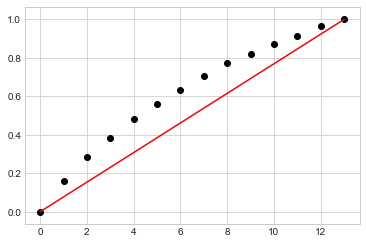

In [589]:
preds_dist_clf = clf.predict_proba(dist_feature_test)
plot_top_n(clf, preds_dist_clf)

Let's try another classifier. This time we will use a pipeline containing a count vectorizer, followed by a term-frequency/inverse-document-frequency transformer, and then finally a Multinomial naive Bayes classifier. 

In [590]:
pipeline = Pipeline([
    #('count_vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('classifier', MultinomialNB())
    #('classifier', SVC())
    #('classifier', DecisionTreeClassifier())
])
pipeline.fit(x_train, y_train)
print(accuracy_score(y_test, pipeline.predict(x_test)))
print(confusion_matrix(y_test, pipeline.predict(x_test)))

0.209226257613
[[  0   0  36 112  36 114 141  14   0  53  41 113  22]
 [  0 245   2  93   0  20  30   0  51  62  61   0 118]
 [ 38  46  34  30  42  61  78  24  48  91  55  37  98]
 [ 27  30  13 124  65  53  23  71  17  87  57  52  63]
 [ 22  41  29  90 136  91  22  42  25  61  34  61  28]
 [ 20  25  20  66  76 133  18 104  17 104  27  42  30]
 [ 47  34  16  63  14  11 166  22  15  34 105  54 101]
 [ 12  16   7  37  59  72  16 298  10  54  32  45  24]
 [ 58  53  41  51  54  24  50  14  68  64  74  42  89]
 [ 22  31  30  61  53  54  24  76  13 202  54  36  26]
 [ 38  72  20  45  19  11  61  27  21  47 183  34 104]
 [ 29  35  23  46  70  67  34  48  23  64  60  97  86]
 [ 27  48  19  47  22  22  52  16  22  59 134  45 169]]


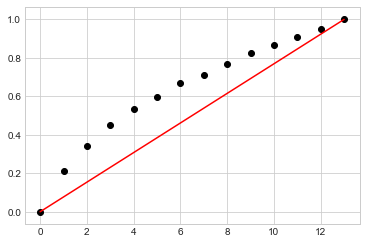

In [591]:
preds_pipeline = pipeline.predict_proba(x_test)
plot_top_n(pipeline, preds_pipeline)

Now let's try averaging the class probabilities of the two classifiers:

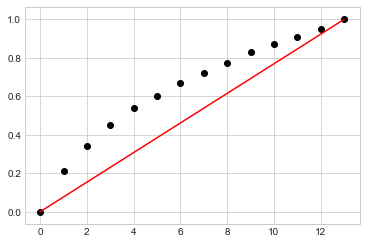

In [592]:
preds_combined = np.divide(np.add(preds_pipeline, preds_dist_clf), 2)
plot_top_n(pipeline, preds_combined)

The following image is psychologist Robert Plutchik's conception of the wheel of emotions. Note that the four cardinal emotions are "ecstasy", "grief", "rage", and "terror".

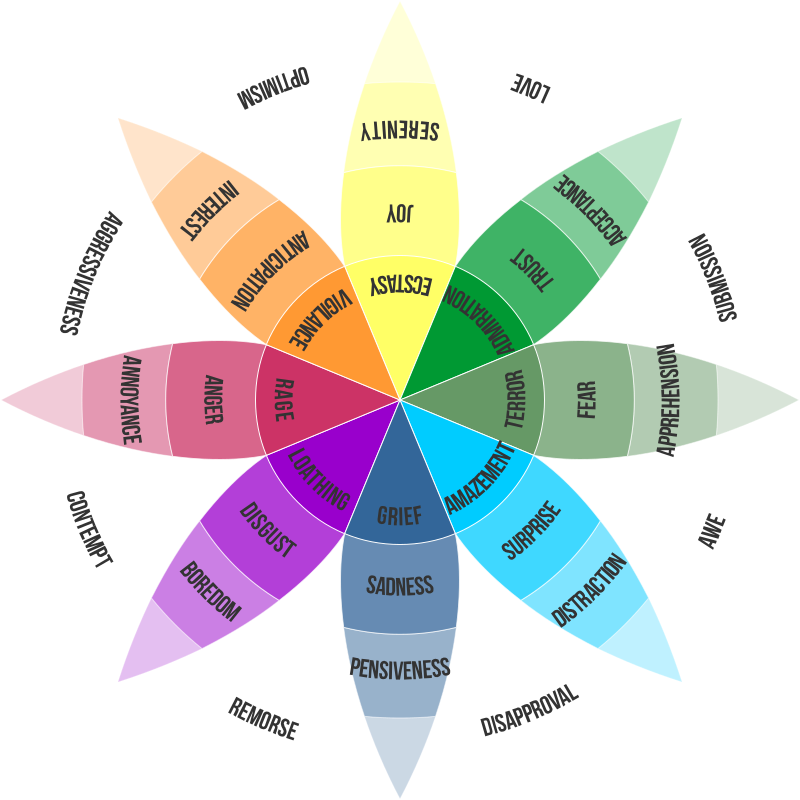

In [593]:
from IPython.display import Image
Image("plutchik_emotions.png")

We will try to reduce the number of classes by transforming each of the orignal 13 emotions into their approximate form with respect to the previously mentioned cardinal emotions. 

In [606]:
DENSE_EMOTIONS_DICT = {'empty':'grief', 'sadness':'grief', 
        'enthusiasm':'ecstasy','love':'ecstasy', 'fun':'ecstasy', 'happiness':'ecstasy', 'relief':'ecstasy', 
        'worry':'terror', 'surprise':'terror', 
        'anger':'rage', 'hate':'rage', 
        'neutral':'neutral', 'boredom':'neutral'}

DENSE_EMOTIONS = {'grief', 'ecstasy', 'terror', 'rage', 'neutral'}

DENSE_EMOTION_TO_EMOTIONS_DICT = {'grief': ['empty', 'sadness'], 'ecstasy': ['enthusiasm', 'love', 'fun', 'happiness', 'relief' ], \
                                   'terror': ['worry', 'surprise'], 'rage': ['hate', 'anger'], 'neutral': ['neutral', 'boredom']}

d = collections.defaultdict(list)
y = []

with open('text_emotion.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader, None)  # skip the headers
    for row in reader: 
        d[DENSE_EMOTIONS_DICT[row[1]]] += [row[3]]
        y.append(DENSE_EMOTIONS_DICT[row[1]])

count = collections.Counter(y)
count

Counter({'ecstasy': 13112,
         'grief': 5992,
         'neutral': 8817,
         'rage': 1433,
         'terror': 10646})

In [607]:
### Fix data imbalance
min_count = float('inf')
for emotion in DENSE_EMOTIONS: 
    if count[emotion] < min_count: 
        min_count = count[emotion]
max_count_train = math.floor(0.8*min_count)
max_count_test = min_count - max_count_train

d_train = collections.defaultdict(list)
d_test = collections.defaultdict(list)

### Add all of data for the emotion with least data points
for emotion in DENSE_EMOTIONS: 
    d_train[emotion] += d[emotion][:max_count_train]
    d_test[emotion] += d[emotion][max_count_train:min_count]
    d[emotion] = d[emotion][min_count:]

In [608]:
CLONE_N = 5 ### More data means smaller clone_n
fix_imbalance(DENSE_EMOTIONS)

In [609]:
x_train = []
y_train = []
x_test = []
y_test = []

for emotion in DENSE_EMOTIONS: 
    x_train += d_train[emotion]
    y_train += [emotion for ___ in range(len(d_train[emotion]))]
    x_test += d_test[emotion]
    y_test += [emotion for ___ in range(len(d_test[emotion]))]

In [610]:
combined = list(zip(x_train, y_train))
random.shuffle(combined)
x_train[:], y_train[:] = zip(*combined)

combined = list(zip(x_test, y_test))
random.shuffle(combined)
x_test[:], y_test[:] = zip(*combined)

In [611]:
x_train = clean(x_train)
x_test = clean(x_test)

In [612]:
dist_feature_train = distance_transformer(x_train, DENSE_EMOTIONS)
dist_feature_test = distance_transformer(x_test, DENSE_EMOTIONS)

#sent_feature_train = sentiment_transformer(x_train) ### Doesn't add any benefits
#sent_feature_test = sentiment_transformer(x_test)

#total_feature_train = [dist_feature_train[i] + sent_feature_train[i] for i in range(len(dist_feature_train))]
#total_feature_test = [dist_feature_test[i] + sent_feature_test[i] for i in range(len(dist_feature_test))]

/Users/ianscottknight/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ianscottknight/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Let's again implement our first classifier, a simple naive bayes classifier where the input features are the cosine distances of the average vector of the word vectors of a given piece of text from the emotion words in vector space.

In [613]:
clf = MultinomialNB()
clf.fit(dist_feature_train, y_train)
print(accuracy_score(y_test, clf.predict(dist_feature_test)))
print(confusion_matrix(y_test, clf.predict(dist_feature_test)))

0.330429732869
[[866  84 371 230 171]
 [459 145 459 366 293]
 [416  83 667 310 246]
 [348  46 350 804 174]
 [413 145 413 388 363]]


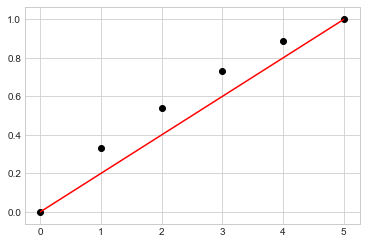

In [615]:
preds_dist_clf = clf.predict_proba(dist_feature_test)
plot_top_n(clf, preds_dist_clf)

Let's try another classifier. This time we will use a pipeline containing a count vectorizer, followed by a term-frequency/inverse-document-frequency transformer, and then finally a Multinomial naive Bayes classifier. 

In [616]:
pipeline = Pipeline([
    #('count_vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('classifier', MultinomialNB())
    #('classifier', SVC())
    #('classifier', DecisionTreeClassifier())
])
pipeline.fit(x_train, y_train)
print(accuracy_score(y_test, pipeline.predict(x_test)))
print(confusion_matrix(y_test, pipeline.predict(x_test)))

0.350522648084
[[939 237 178 105 263]
 [305 566 167 227 457]
 [519 299 342 202 360]
 [376 269 186 504 387]
 [263 410 139 243 667]]


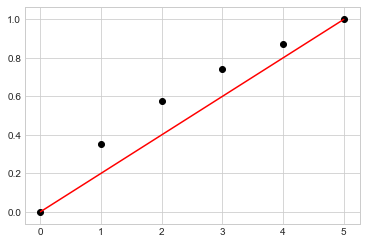

In [617]:
preds_pipeline = pipeline.predict_proba(x_test)
plot_top_n(pipeline, preds_pipeline)

Now let's try averaging the class probabilities of the two classifiers:

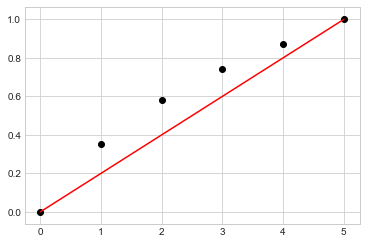

In [618]:
preds_combined = np.divide(np.add(preds_pipeline, preds_dist_clf), 2)
plot_top_n(pipeline, preds_combined)